In [1]:
import torch
from data_handler import DataHandler, load_encoded_data, load_json, save_json
from model import TravelDocClassifier
from cuda_utils import clear_cache, print_cuda_memory_info

c:\Users\wei\Desktop\programs\information-retrieval\ir_final_doc_classifier\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
clear_cache()
print_cuda_memory_info()

Device: NVIDIA GeForce RTX 4070 SUPER
Total Memory: 12.88 GB
Reserved Memory: 0.00 GB
Allocated Memory: 0.00 GB
Free Memory: 0.00 GB


### Testing

In [3]:
data_handler = DataHandler(tokenizer_name='bert-base-chinese')

encodings, labels = load_encoded_data('encoded_data/test')

test_dataset = data_handler.create_dataset(encodings, labels)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classifier = TravelDocClassifier(device=device, params_path='parameters/20240602_94_model_parameters.pth')
test_accuracy, confusion = classifier.test(test_dataset)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
print(confusion)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\wei\Desktop\programs\information-retrieval\ir_final_doc_classifier\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Test Accuracy: 0.95%
Confusion Matrix:
[[2645  243]
 [ 343 7472]]


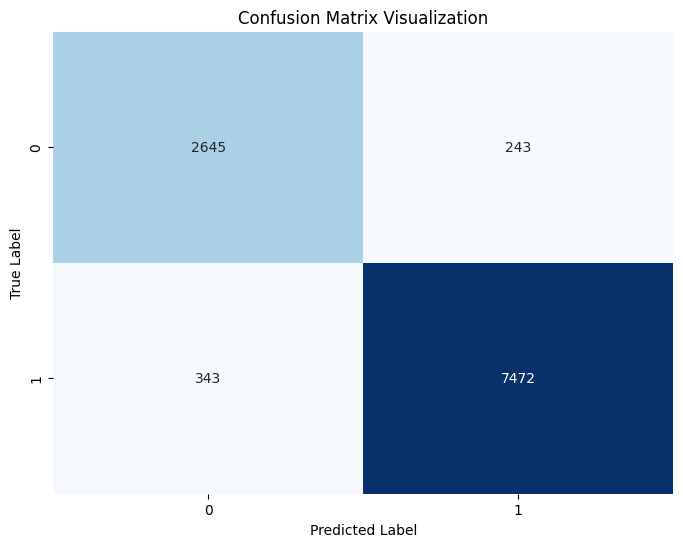

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 使用 Seaborn 的 heatmap 函數來創建熱力圖
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)

# 加入標籤和標題
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Visualization')
plt.show()

In [7]:
tp, fn, fp, tn = confusion.ravel()

# 精確率 (Precision)
precision = tp / (tp + fp)

# 召回率 (Recall)
recall = tp / (tp + fn)

# 特異性 (Specificity)
specificity = tn / (tn + fp)

print(f"精確率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"特異性 (Specificity): {specificity:.4f}")

精確率 (Precision): 0.8852
召回率 (Recall): 0.9159
特異性 (Specificity): 0.9561


### Prediction

In [8]:
filtered_data = load_json('filtered_data/all.json')

In [9]:
data_handler = DataHandler(tokenizer_name='bert-base-chinese')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

travel_related = []
non_travel_related = []

for doc in filtered_data:
    content = doc['content']
    input = data_handler.prepare_input_for_prediction(content)

    classifier = TravelDocClassifier(device=device, params_path='parameters/20240602_94_model_parameters.pth')
    pred_label = classifier.predict(input)

    if pred_label == 1:
        travel_related.append(doc)
    else:
        non_travel_related.append(doc)

len(travel_related), len(non_travel_related)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FileNotFoundError: [Errno 2] No such file or directory: 'parameters/20240513_fold_3_model_parameters.pth'

In [ ]:
save_json(travel_related, 'results/travel_related_predictions.json')
save_json(non_travel_related, 'results/non_travel_related_predictions.json')